In [1]:
import json
import re
import subprocess

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
import matplotlib.ticker as mticker

from urllib.request import urlopen, HTTPError
from wordcloud import WordCloud, STOPWORDS

In [2]:
def make_wordcloud(df, column_name, ftitle):
    
    text = ' '.join(df[column_name].values)
    
    exclude = [
        'using',
        'CMS',
        'open',
        'data',
        'collider',
        'event',
        'TeV',
        'analysis',
        'based',
        'LHC',
        'particle',
        'end',
        'high',
        'energy',
        'physics',
        'new',
        'experiment'
    ]

    stopwords = set(STOPWORDS)

    for e in exclude:
        stopwords.add(e)
    
    wc = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=600,
        height=400
    ).generate(text)
    
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    #plt.show()

    plt.savefig(f'./figs/{ftitle}.png', dpi=200)

In [3]:
def handle_doi_queries(dois):
    
    doi_url = 'https://doi.org/api/handles/'
    recids = []
        
    for doi in dois:
        '''
        Some of the DOIs referenced are invalid, either having an extra ":" 
        appended to the end or having the year in parentheses appended.
        In the former case they are duplicates and we can skip.
        In the latter clean them up.
        '''
        
        if ':' in doi:
            continue
        if '(' in doi:
            doi = doi[:-6]
            
        try:
            response = json.load(
                urlopen(f'{doi_url}{doi}')
            )
        
            url = response['values'][1]['data']['value']
            recid = url.split('/')[-1]
        
            recids.append(recid)
         
        except HTTPError:
            print('Error '+doi)
        
    return recids
    
def resolve_dois(df):
    '''
    The references that come from the Inspire API results
    often have useful information on the datasets in "misc"
    and often has the CODP records as well. In several cases
    they do not. Since we have the DOIs use the DOI API
    
    https://www.doi.org/the-identifier/resources/factsheets/doi-resolution-documentation
    
    and resolve the CODP record URL and add it to the dataframe.
    
    We can get the information from the DOI using the CODP CLI as well
    (and that's probably better but stay with this for now).
    '''
    df['codp_recids'] = df['dois_referenced'].map(
        lambda x: handle_doi_queries(x)
    )

In [4]:
def process_dataframe(input_json):
    
    exclude_names = [
        'McCauley',
        'Bellis',
        'Lange',
        'Tibor',
        'Šimko',
        'Carerra',
        'Geiser',
        'Lassila-Perini',
        'Dallmeier-Tiessen',
        'Calderon',
        'Rao',
        'Socher',
        'Herterich'
    ]
    
    df = pd.read_json(input_json)
    
    '''
    Adds a new column where each row is a list of names from exclude_names 
    that match (substring) those in the author list contained in the authors column
    '''
    df['exclude'] = df['authors'].map(lambda x: [e for e in exclude_names if any(e in xn for xn in x)])
    
    print(df.shape[0])
    
    '''
    Filter out rows in-place where there are matches from the
    excluded names
    '''
    df = df[df['exclude'].str.len() == 0]
    
    print(df.shape[0])
    
    '''
    Reorder the rows by date and reorder the indices. 
    Then add an index column.
    '''
    df.sort_values(by='date', inplace=True)
    df.reset_index(drop='True', inplace=True)
    df.reset_index(inplace=True)
    
    '''
    Format date
    '''
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    
    return df

In [5]:
def make_histogram(df, date_range, nbins, title, ftitle):
    
    dates = df['date'].to_numpy(dtype='datetime64[Y]')
    
    h, b = np.histogram(
        dates.astype(int),
        range=date_range,
        bins=nbins
    )

    b = np.array([np.datetime64(int(value), 'Y') for value in b])

    plt.bar(b[:-1], h, width=np.diff(b), ec='black', align='edge')
    plt.gca().set_xticks(b)
    plt.gca().set_xticklabels(b, rotation=45)

    plt.title(title)

    plt.tight_layout()
    plt.savefig(f'./figs/{ftitle}.png', dpi=200)

In [6]:
data_releases = [
    '2014-11-20',
    '2016-04-22',
    '2017-12-20',
    '2019-07-18',
    '2020-08-27',
    '2020-12-21',
    '2021-12-20',
    '2022-12-05',
    '2023-09-18',
    '2024-04-02'
]

These papers reference a CMS open data DOI

In [7]:
idf = process_dataframe('data/inspire.json')

98
81


In [8]:
resolve_dois(idf)

Error 10.7483/OPENDATA.CMS.7347
Error 10.7483/OPENDATA.CMS.29BN
Error 10.7483/OPENDATA.CMS.4RTG
Error 10.7483/OPENDATA.CMS


In [9]:
date_generated = dt.datetime.today().strftime('%Y-%m-%d')
print(
    date_generated
)

2025-07-15


In [10]:
idf.head()

,index,abstract,authors,citations,date,document_type,doi,dois_referenced,keywords,publication,title,url,exclude,codp_recids
0,0,The splitting function is a universal property...,"[Larkoski, Andrew, Marzani, Simone, Thaler, Je...",72,2017-04-19,article,10.1103/PhysRevLett.119.132003,"[10.7483/OPENDATA.CMS.3S7F.2E9W, 10.7483/OPEND...","[jet: energy, energy: high, singularity: colli...",Phys.Rev.Lett.,Exposing the QCD Splitting Function with CMS O...,https://inspirehep.net/literature/1591972,[],"[5, 21]"
1,1,The application of deep learning techniques us...,"[Madrazo, Celia Fernández, Cacha, Ignacio Here...",16,2017-08-25,conference paper,10.1051/epjconf/201921406017,"[10.7483/opendata.cms.txt4.4rrp, 10.7483/opend...","[Deep Learning, Machine Learning, Convolutiona...",EPJ Web Conf.,Application of a Convolutional Neural Network ...,https://inspirehep.net/literature/1618344,[],"[1395, 1633, 1544]"
2,2,Daily operation of a large-scale experiment is...,"[Borisyak, Maxim, Ratnikov, Fedor, Derkach, De...",15,2017-09-26,conference paper,10.1088/1742-6596/898/9/092041,"[10.7483/OPENDATA.CMS.6BPY.XFRQ:, 10.7483/OPEN...","[data acquisition, quality: monitoring, CMS, C...",J.Phys.Conf.Ser.,Towards automation of data quality system for ...,https://inspirehep.net/literature/1625297,[],"[8, 14, 12]"
3,3,The need for processing the ever-increasing am...,"[Piparo, D., Tejedor, E., Guiraud, E., Ganis, ...",3,2017-11-27,conference paper,10.1088/1742-6596/898/7/072022,[10.7483/OPENDATA.CMS.JCDC.9CUH],[],J.Phys.Conf.Ser.,Expressing Parallelism with ROOT,https://inspirehep.net/literature/1638554,[],[1640]
4,4,Deep generative models parametrised by neural ...,"[Musella, Pasquale, Pandolfi, Francesco]",95,2018-05-03,article,10.1007/s41781-018-0015-y,"[10.7483/OPENDATA.CMS.Q3BX.69VQ, 10.7483/OPEND...","[Generative adversarial networks, Deep learnin...",Comput.Softw.Big Sci.,Fast and Accurate Simulation of Particle Detec...,https://inspirehep.net/literature/1671151,[],"[1539, 1555, 1562, 1348, 1369, 1469, 1553, 155..."


In [11]:
idf.tail()

,index,abstract,authors,citations,date,document_type,doi,dois_referenced,keywords,publication,title,url,exclude,codp_recids
76,76,A search is performed for pairs of light pseud...,"[Perez Adan, Danyer]",0,2025-04-17,article,,"[10.7483/OPENDATA.CMS.DM27.QUP0, 10.7483/OPEND...",[],,Search for an exotic decay of the 125 GeV Higg...,https://inspirehep.net/literature/2912807,[],"[30530, 30563, 63164, 63186, 63204, 63222, 632..."
77,77,We argue that collider observables such as had...,"[Chang, Cyuan-Han, Chen, Hao, Simmons-Duffin, ...",2,2025-06-10,article,,"[10.7483/OPENDATA.CMS.7347.JDWH, 10.7483/OPEND...",[],,Seeing through the confinement screen: DGLAP/B...,https://inspirehep.net/literature/2932054,[],"[414, 21]"
78,78,Collider experiments offer a unique opportunit...,"[Moult, Ian, Zhu, Hua Xing]",3,2025-06-12,article,,"[10.7483/OPENDATA.CMS.UP77.P6PQ, 10.7483/OPEND...",[],,Energy Correlators: A Journey From Theory to E...,https://inspirehep.net/literature/2933390,[],"[21, 5]"
79,79,In the pursuit of deeper understanding of the ...,"[Belis, Vasilis]",0,2025-06-13,thesis,10.3929/ethz-b-000737534,"[10.7483/OPENDATA.CMS.3R3P.5JYR, 10.7483/OPEND...","[Quantum Computing, Machine Learning, High Ene...",,Quantum Machines Learning from Elementary Part...,https://inspirehep.net/literature/2934142,[],"[1350, 1487]"
80,80,Vector-like quark partners appear in many BSM ...,"[Ghosh, Anupam, Ghosh, Soumyadip, Mitra, Soure...",0,2025-07-08,article,,"[10.7483/OPENDATA.CMS, 10.7483/OPENDATA.CMS.4U...",[],,Improving Sensitivity of Vector-like Top Partn...,https://inspirehep.net/literature/2942757,[],"[19949, 19933, 19940, 19941, 19942, 19943, 199..."


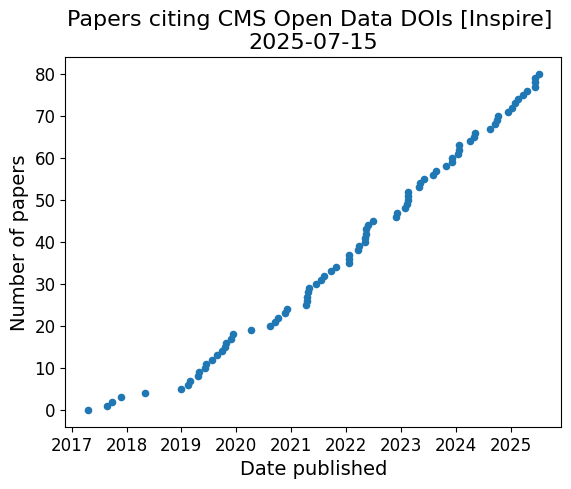

In [80]:
def add_release_dates(ax):
    
    ax.set_xlim([dt.date(2014, 1, 1), dt.date(2026, 1, 1)])

    for dr in data_releases:
    
        date = dt.datetime.strptime(dr, '%Y-%m-%d').date()

        ax.annotate(
            "",
            xy=(date, -3), 
            xytext=(date, -2),        
            arrowprops=dict(facecolor='black', shrink=0.01),
        )


ax = idf.plot(
    kind='scatter',
    x='date', 
    y='index',
    #title=f'Papers citing CMS Open Data DOIs [Inspire] \n{date_generated}'
)

ax.set_xlabel('Date published', fontsize=14)
ax.set_ylabel('Number of papers', fontsize=14)
ax.set_title(f'Papers citing CMS Open Data DOIs [Inspire] \n{date_generated}', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#add_release_dates(ax)
plt.savefig('./figs/inspire-npapers.png', dpi=200)

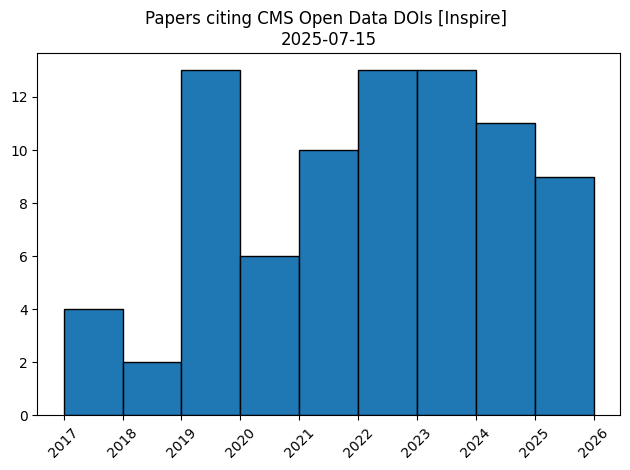

In [81]:
make_histogram(
    idf,
    (np.datetime64('2017').astype(int), np.datetime64('2026').astype(int)),
    9,
    f'Papers citing CMS Open Data DOIs [Inspire] \n{date_generated}',
    'inspire-npapers-hist'
)

In [82]:
nzero = len(idf[idf['citations'] == 0])

nzdf = idf[idf['citations'] > 0]

print(f'{nzero} papers with 0 citations')
print(f'{len(nzdf)} papers with > 0 citations')

20 papers with 0 citations
61 papers with > 0 citations


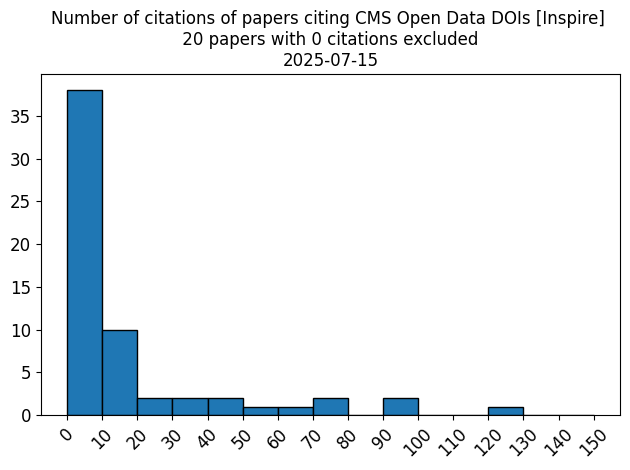

In [83]:
h, b = np.histogram(
    nzdf['citations'],
    range=(0,150),
    bins=15
)

plt.bar(b[:-1], h, width=np.diff(b), ec='black', align='edge')

plt.gca().set_xticks(b)
plt.xticks(fontsize=12)
plt.gca().set_xticklabels(b.astype(int), rotation=45)
plt.yticks(fontsize=12)

#plt.gca().set_yscale('log')
plt.title(
    f'Number of citations of papers citing CMS Open Data DOIs [Inspire] \n {nzero} papers with 0 citations excluded \n{date_generated}'
)

plt.tight_layout()

plt.savefig('./figs/inspire-citations.png', dpi=200)

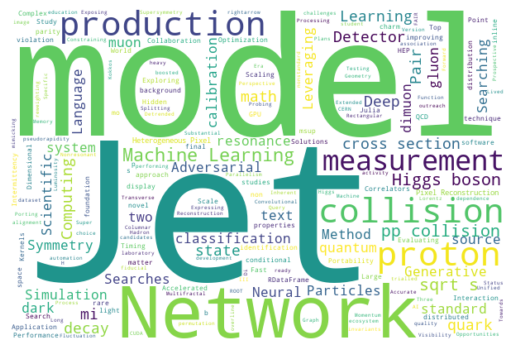

In [84]:
make_wordcloud(idf, 'title', 'inspire-wc-title')

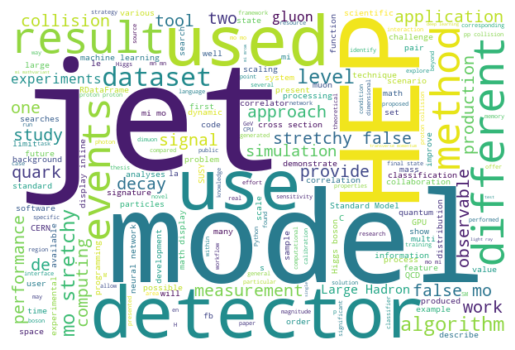

In [85]:
make_wordcloud(idf, 'abstract', 'inspire-wc-abstract')

In [19]:
def get_codp_title(recid):
    
    results = subprocess.run([
        'cernopendata-client',
        'get-metadata',
        '--recid',
        recid,
        '--output-value',
        'title'],
        stdout=subprocess.PIPE
    )
    
    return results.stdout.decode('utf-8')

In [20]:
def get_codp_categories(recid):

    results = subprocess.run([
        'cernopendata-client',
        'get-metadata',
        '--recid',
        recid,
        '--output-value',
        'categories'],
        stdout=subprocess.PIPE
    )

    results = results.stdout.decode('utf-8')

    if 'ERROR' in results:
        return '', []
    
    categories = json.loads(results)
    
    return categories['primary'], categories['secondary']

In [21]:
titles = idf['codp_recids'].map(lambda x: [get_codp_title(str(rid)) for rid in x])

In [22]:
categories = idf['codp_recids'].map(lambda x: [get_codp_categories(str(rid)) for rid in x])

In [57]:
# Make this more pythonic

primary_categories = []
secondary_categories = []

for c in categories:

    if len(c) > 0:

        for d in c:

            if d[0]:
                primary_categories.append(d[0])
            if d[1]:
                for e in d[1]:
                    secondary_categories.append(e)

print(primary_categories)
print(secondary_categories)

['Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard Model Physics', 'Standard M

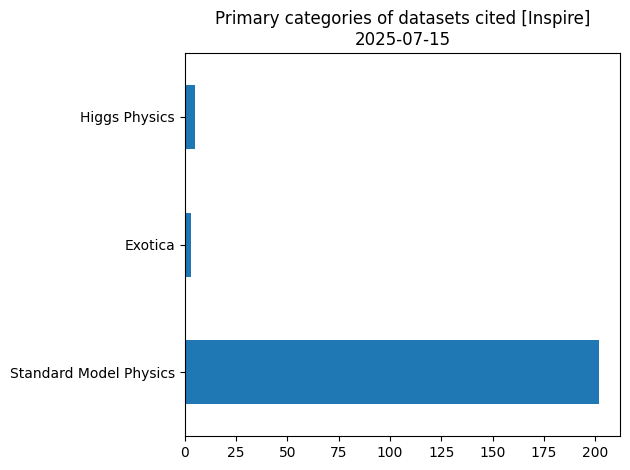

In [86]:
pd.Series(primary_categories).value_counts(sort=False).plot(
    kind='barh',
    title=f'Primary categories of datasets cited [Inspire]\n{date_generated}',
    #figsize=(12,20)
)

plt.tight_layout()
plt.savefig('./figs/inspire-dataset-primary-categories.png', dpi=200)

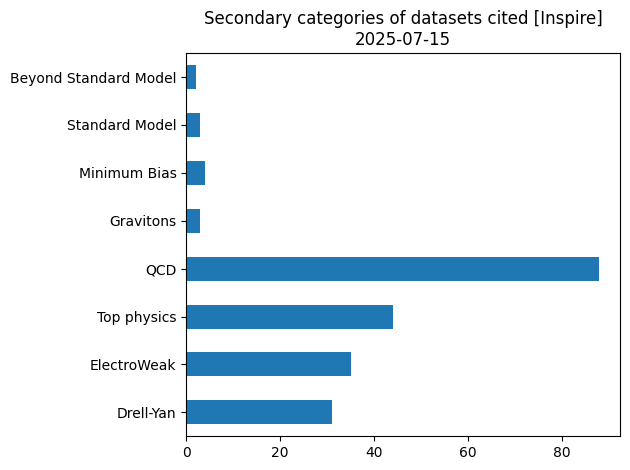

In [87]:
pd.Series(secondary_categories).value_counts(sort=False).plot(
    kind='barh',
    title=f'Secondary categories of datasets cited [Inspire]\n{date_generated}',
    #figsize=(12,20)
)

plt.tight_layout()
plt.savefig('./figs/inspire-dataset-secondary-categories.png', dpi=200)

In [88]:
titles = [[t.rstrip() for t in title] for title in titles]

In [89]:
'''
Fetch out the dataset names by searching for /A/B/C pattern.

Useful information:
- A
- Run201XY from B
- C
'''

dataset_names = []
dataset_eras = []
dataset_tiers = []

others = []

for title in titles:
    for t in title:
        
        if len(re.findall('/', t)) == 3:
            
            t = t.split('/')
            
            if 'Run201' in t[2]:
                dataset_eras.append(t[2].split('-')[0])
                
            dataset_names.append(t[1])
            dataset_tiers.append(t[3])
            
        else:
            others.append(t)
    

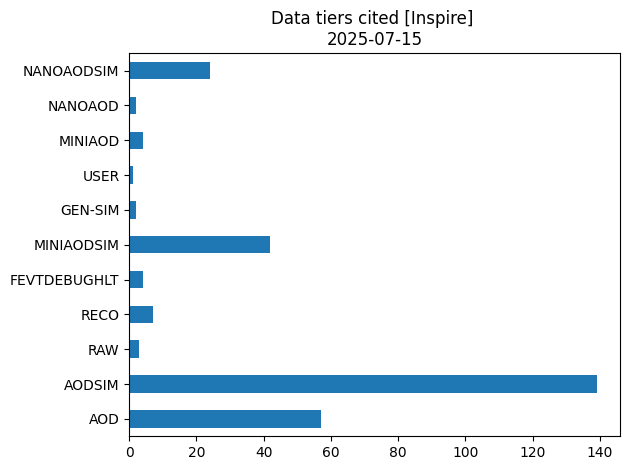

In [90]:
pd.Series(dataset_tiers).value_counts(sort=False).plot(
    kind='barh',
    title=f'Data tiers cited [Inspire] \n{date_generated}'
)

plt.tight_layout()
plt.savefig('./figs/inspire-datatiers.png', dpi=200)

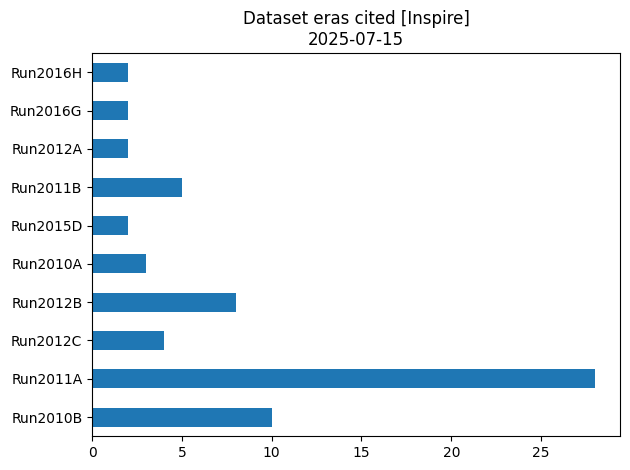

In [91]:
pd.Series(dataset_eras).value_counts(sort=False).plot(
    kind='barh',
    title=f'Dataset eras cited [Inspire]\n{date_generated}'
)

plt.tight_layout()
plt.savefig('./figs/inspire-dataset-eras.png', dpi=200)

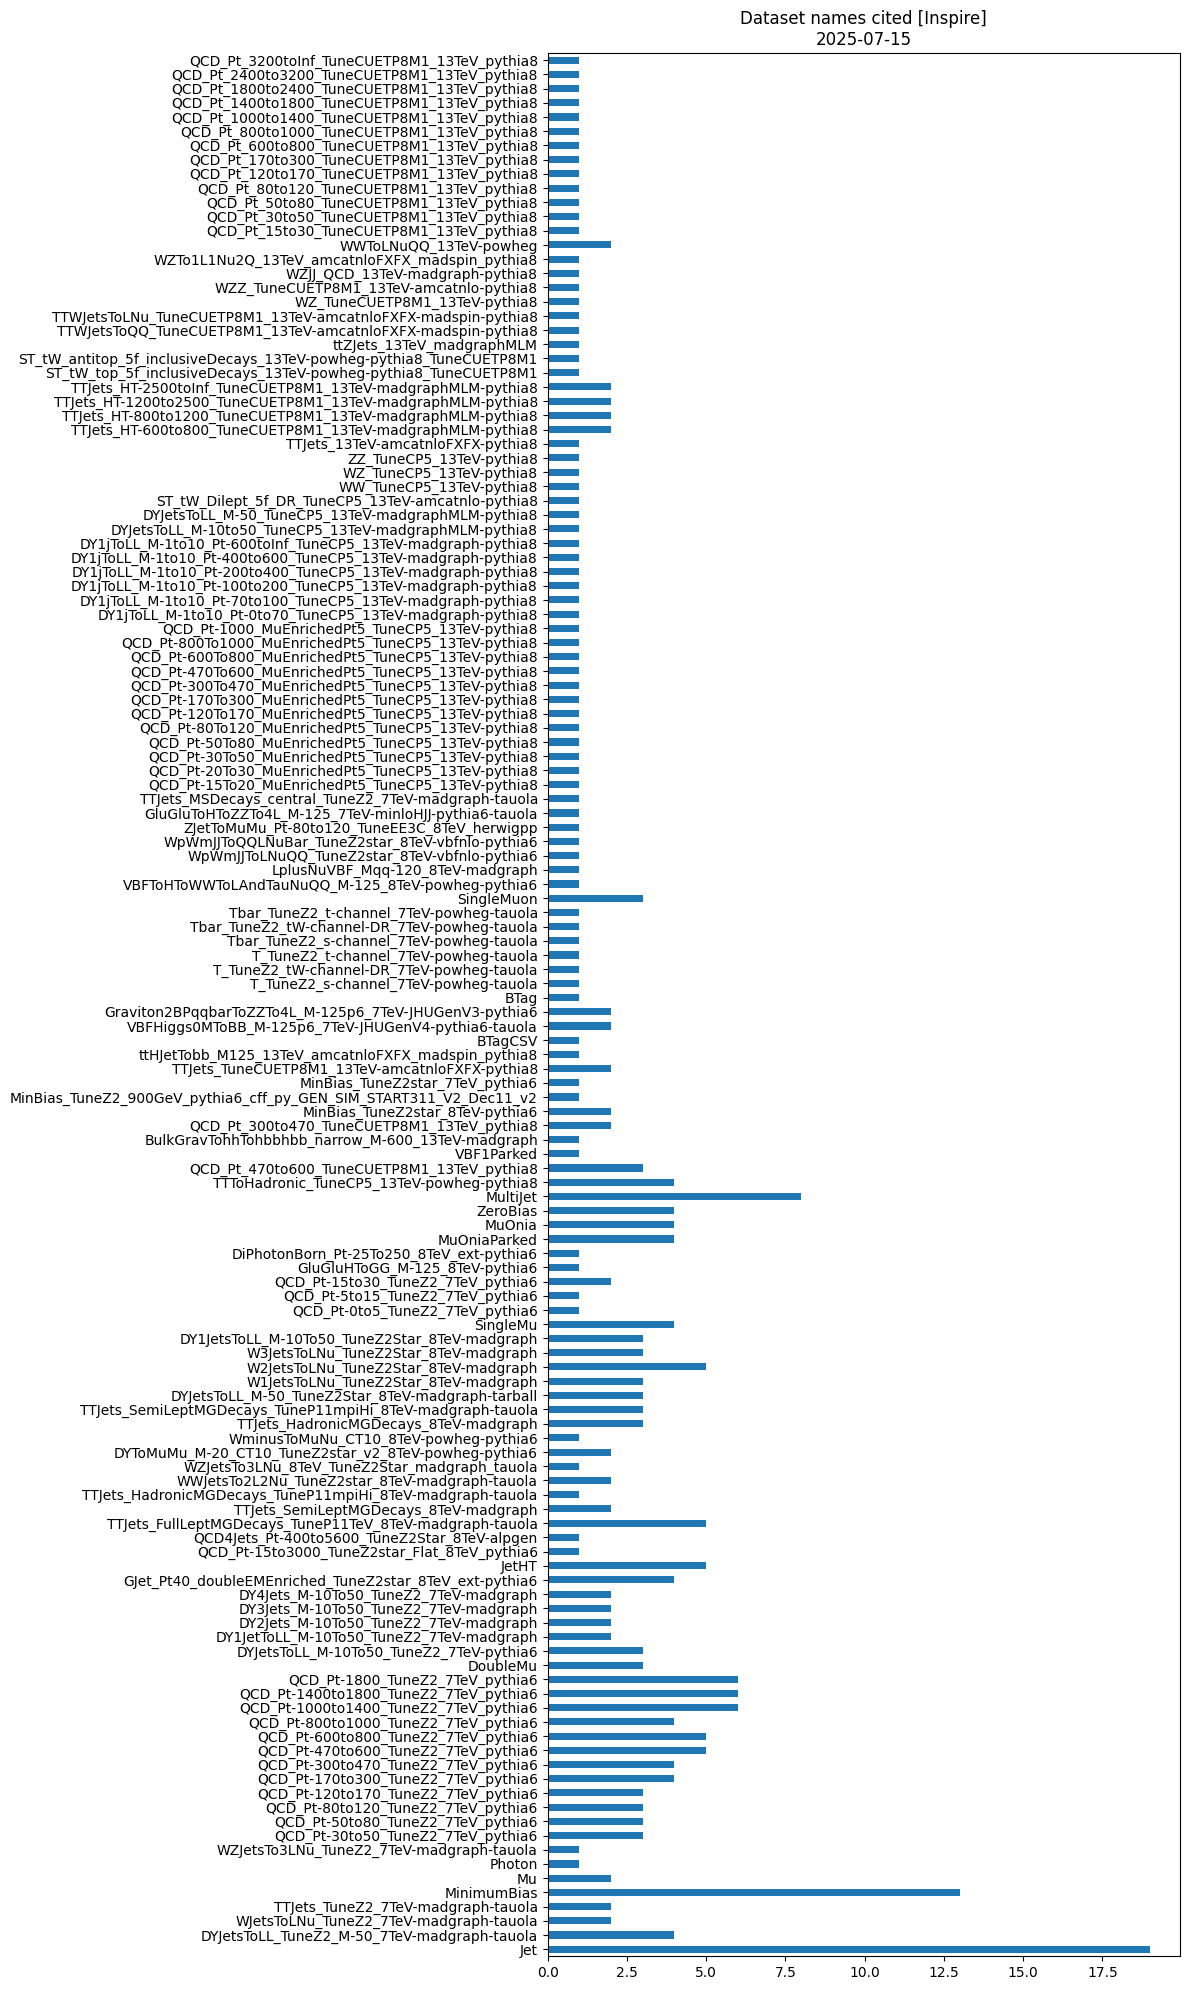

In [93]:
pd.Series(dataset_names).value_counts(sort=False).plot(
    kind='barh',
    title=f'Dataset names cited [Inspire]\n{date_generated}',
    figsize=(12,20)
)

plt.tight_layout()
plt.savefig('./figs/inspire-dataset-names.png', dpi=200)

In [94]:
publications = idf['publication'].values
publications = [p for p in publications if p]

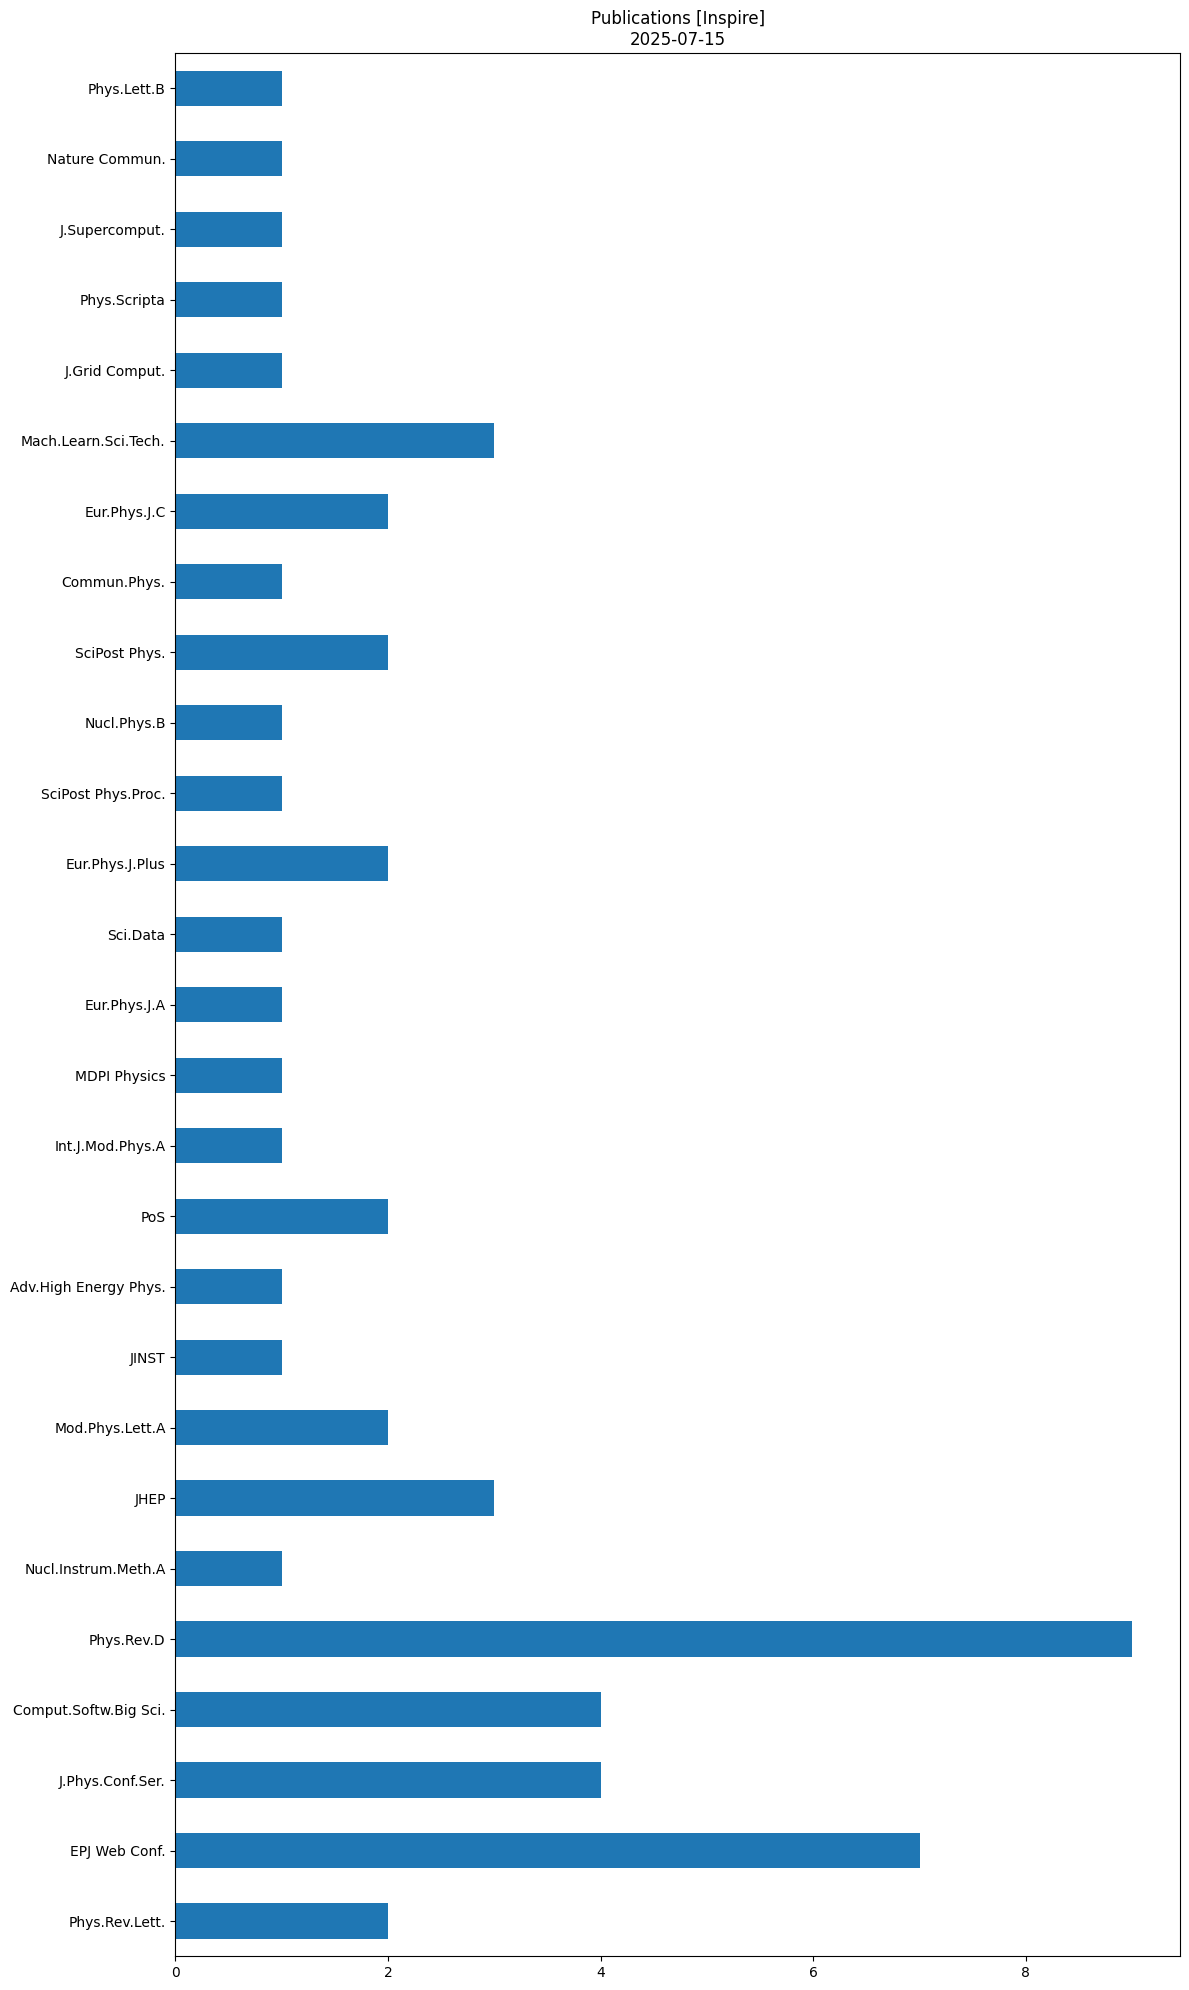

In [95]:
pd.Series(publications).value_counts(sort=False).plot(
    kind='barh',
    title=f'Publications [Inspire]\n{date_generated}',
    figsize=(12,20)
)

plt.tight_layout()
plt.savefig('./figs/inspire-publications.png', dpi=200)

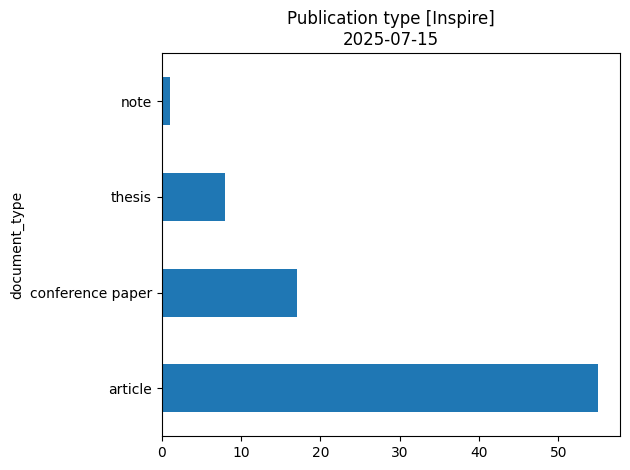

In [96]:
idf['document_type'].value_counts(sort=False).plot(
    kind='barh',
    title=f'Publication type [Inspire]\n{date_generated}'
)

plt.tight_layout()
plt.savefig('./figs/inspire-publication-type.png', dpi=200)

In [97]:
adf = process_dataframe('data/arxiv.json')

38
37


In [98]:
adf.head()

,index,abstract,authors,date,doi,title,url,exclude
0,0,The splitting function is a universal property...,"[Andrew Larkoski, Simone Marzani, Jesse Thaler...",2017-04-17,http://dx.doi.org/10.1103/PhysRevLett.119.132003,Exposing the QCD Splitting Function with CMS O...,http://arxiv.org/abs/1704.05066v3,[]
1,1,We use public data from the CMS experiment to ...,"[Aashish Tripathee, Wei Xue, Andrew Larkoski, ...",2017-04-19,http://dx.doi.org/10.1103/PhysRevD.96.074003,Jet Substructure Studies with CMS Open Data,http://arxiv.org/abs/1704.05842v3,[]
2,2,This paper describes the construction of novel...,"[Michael Andrews, Manfred Paulini, Sergei Gley...",2018-07-31,http://dx.doi.org/10.1007/s41781-020-00038-8,End-to-End Physics Event Classification with C...,http://arxiv.org/abs/1807.11916v3,[]
3,3,We study dimuon events in 2.11/fb of 7 TeV pp ...,"[Cari Cesarotti, Yotam Soreq, Matthew J. Stras...",2019-02-12,http://dx.doi.org/10.1103/PhysRevD.100.015021,Searching in CMS Open Data for Dimuon Resonanc...,http://arxiv.org/abs/1902.04222v2,[]
4,4,We describe the construction of end-to-end jet...,"[Michael Andrews, John Alison, Sitong An, Patr...",2019-02-21,http://dx.doi.org/10.1016/j.nima.2020.164304,End-to-End Jet Classification of Quarks and Gl...,http://arxiv.org/abs/1902.08276v2,[]


In [99]:
adf.tail()

,index,abstract,authors,date,doi,title,url,exclude
32,32,Identifying jets originating from bottom quark...,"[Ayse Asu Guvenli, Bora Isildak]",2024-12-11,http://arxiv.org/abs/2412.08134v1,B-Jet Tagging with Retentive Networks: A Novel...,http://arxiv.org/abs/2412.08134v1,[]
33,33,We investigate quantum correlations in Higgs-b...,"[Mira Varma, Oliver K. Baker]",2025-02-05,http://arxiv.org/abs/2502.03219v4,Bell Inequalities and Quantum Correlations in ...,http://arxiv.org/abs/2502.03219v4,[]
34,34,We present the first study of anti-isolated Up...,"[Rikab Gambhir, Radha Mastandrea, Benjamin Nac...",2025-02-19,http://arxiv.org/abs/2502.14036v2,Isolating Unisolated Upsilons with Anomaly Det...,http://arxiv.org/abs/2502.14036v2,[]
35,35,A search is performed for pairs of light pseud...,[Danyer Perez Adan],2025-04-16,http://arxiv.org/abs/2504.12161v1,Search for an exotic decay of the 125 GeV Higg...,http://arxiv.org/abs/2504.12161v1,[]
36,36,Distinguishing between quark- and gluon-initia...,"[Md Abrar Jahin, Shahriar Soudeep, Arian Rahma...",2025-06-17,http://arxiv.org/abs/2506.14934v1,Vision Transformers for End-to-End Quark-Gluon...,http://arxiv.org/abs/2506.14934v1,[]


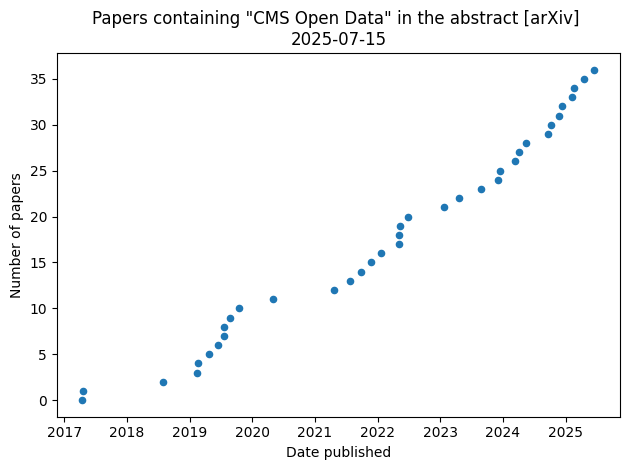

In [100]:
def add_release_dates(ax):
    
    ax.set_xlim([dt.date(2014, 1, 1), dt.date(2024, 12, 31)])

    for dr in data_releases:
    
        date = dt.datetime.strptime(dr, '%Y-%m-%d').date()

        ax.annotate(
            "",
            xy=(date, -1.2), 
            xytext=(date, 0),        
            arrowprops=dict(facecolor='black', shrink=0.01),
        )

ax = adf.plot(
    kind='scatter',
    x='date', 
    y='index',
    title=f'Papers containing "CMS Open Data" in the abstract [arXiv] \n{date_generated}'
)

ax.set_xlabel('Date published')
ax.set_ylabel('Number of papers')

#add_release_dates(ax)

plt.tight_layout()
plt.savefig('./figs/arxiv-npapers.png', dpi=200)

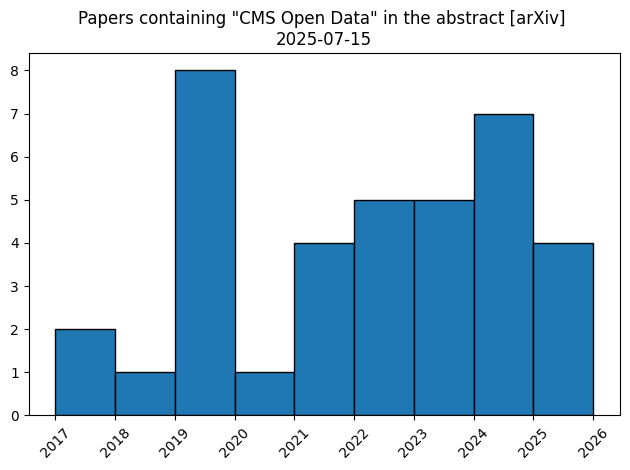

In [101]:
make_histogram(
    adf,
    (np.datetime64('2017').astype(int), np.datetime64('2026').astype(int)),
    9,
    f'Papers containing "CMS Open Data" in the abstract [arXiv] \n{date_generated}',
    'arxiv-npapers-hist'
)

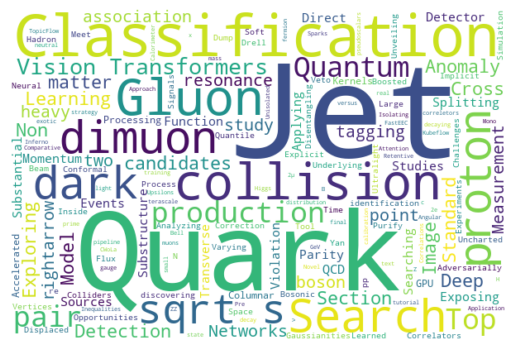

In [102]:
make_wordcloud(adf, 'title', 'arxiv-wc-title')

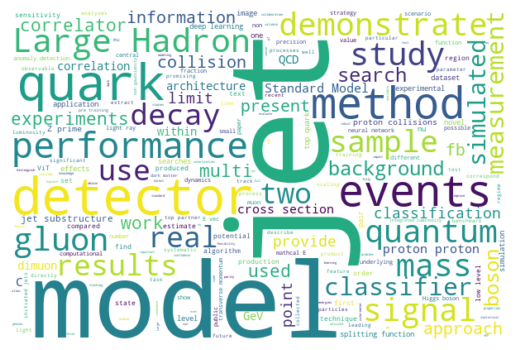

In [103]:
make_wordcloud(adf, 'abstract', 'arxiv-wc-abstract')